## OCR

In [179]:
import string
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from numpy.fft import fft2, ifft2
from bisect import bisect_left
from intervaltree import IntervalTree, Interval
import networkx as nx
import Levenshtein

Funkcja do tworzenia obrazy z tekstem.
Przyjmuje tekst z określoną wielkością fonta, ostateczny rozmiar obrazu jest tak dopasowywany, aby tekst się zmieścił.
Przy testowaniu OCR zakładam, że tekst ma font_size równy przynajmiej 20.
W testach używam dwóch czcionek szeryfowych (Times New Roman i Courier) i dwóch czcionek bezszeryfowych (Arial i Open-sans).
Czcionka Courier jest do tego czcionką o stałej szerokości znaku.
Obraz ma także padding na tyle duży, żeby tekst dało się potem obrócić bez straty informacji i bez zmieniania wymiarów obrazu


In [180]:
def draw_multiline_text(text, size=(800, 600), font_size=40, font='arial', show=False):

    def fit_horizontal():
        return upper_x > padding_x and lower_x < size[0] - padding_x

    def fit_vertical():
        return upper_y > padding_y and lower_y < size[1] - padding_y

    padding_x = size[0] // 7
    padding_y = size[1] // 7
    center = (size[0] // 2, size[1] // 2)
    img = Image.new("RGB", size, (255, 255, 255))
    d = ImageDraw.Draw(img)

    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    upper_x, upper_y, lower_x, lower_y = d.multiline_textbbox(center, text, anchor='mm', font=fnt)
    if not fit_horizontal():
        return draw_multiline_text(text, size = (size[0] + 100, size[1]),
                                   font_size=font_size, font=font, show=show)
    if not fit_vertical():
        return draw_multiline_text(text, size = (size[0], size[1] + 100),
                                   font_size=font_size, font=font, show=show)

    d.multiline_text(center, text, anchor='mm', font=fnt, fill=(0, 0, 0))
    if show:
        display(img)
    return img, font_size

Zbiór znaków do rozpoznawania do liter małych i dużych, cyfr i kilku znaków przestankowych.
Czasami przy porównywaniu wyników nie będę w tym zbiorze uwzględniał kropki i przecinka, gdyż
te znaki są wykrywane w wielu miejscach na obrazie i znacząco zmieniają wynik.

In [181]:
characters = string.ascii_uppercase + string.ascii_lowercase + string.digits + ".,?!/-~"

Znaki któych nie uwzględniam zastępuje spacjami

In [182]:
def filter_text(text):
    return "".join(list(map(lambda x: x if x in characters or x == '\n' else " ", text)))

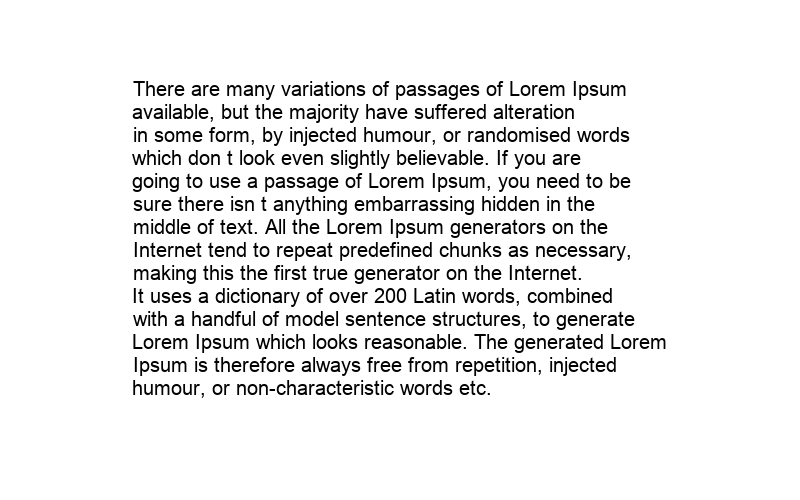

In [183]:
txt = '''There are many variations of passages of Lorem Ipsum
available, but the majority have suffered alteration
in some form, by injected humour, or randomised words
which don't look even slightly believable. If you are
going to use a passage of Lorem Ipsum, you need to be
sure there isn't anything embarrassing hidden in the
middle of text. All the Lorem Ipsum generators on the
Internet tend to repeat predefined chunks as necessary,
making this the first true generator on the Internet.
It uses a dictionary of over 200 Latin words, combined
with a handful of model sentence structures, to generate
Lorem Ipsum which looks reasonable. The generated Lorem
Ipsum is therefore always free from repetition, injected
humour, or non-characteristic words etc.
'''
txt = filter_text(txt)
out, f_size = draw_multiline_text(txt, size= (600, 400), font='arial', font_size=20, show=True)

Funkcja do obracania zdjęcia

In [184]:
def rotate_image(img, angle):
    return img.rotate(angle, fillcolor=(255, 255, 255), resample=Image.BICUBIC)

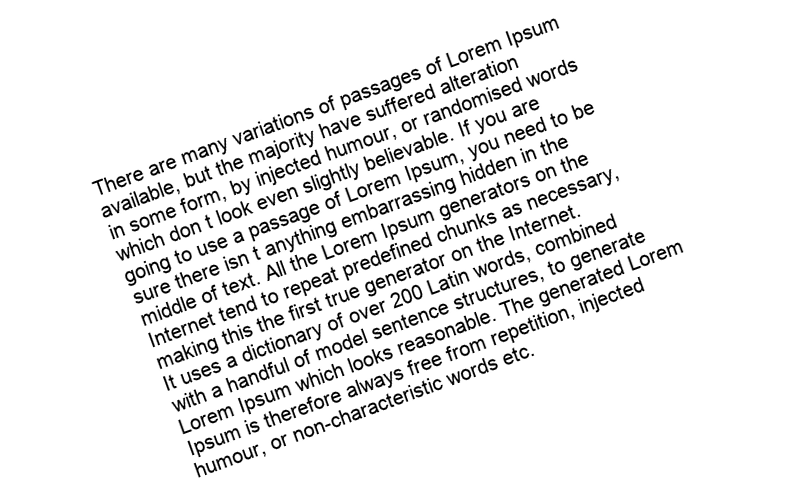

In [185]:
display(rotate_image(out, 20))

Rysowanie pojedynczych liter.
Są rysowane dla konkretnej wielkości czcionki. Używam ich potem jako wzorców przy OCR.

In [186]:
def remove_black_padding(img):
    matrix = np.array(img)
    matrix[:, :np.argmax(matrix[0])] = 255
    return Image.fromarray(matrix)

def draw_single_character(char, font_size, font='arial', show=False):
    img = Image.new("L", (200, 200), 255)
    d = ImageDraw.Draw(img)
    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    w = d.textbbox((0, 0), char, font=fnt)
    d.text((0, 0), char, font=fnt, fill=0)
    img = img.crop(w)
    if char.lower() == 'j':
        img = remove_black_padding(img)
    if show:
        display(img)
    return img

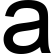

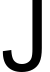

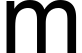

In [187]:
for letter in ['a', 'J', '!', 'm']:
    draw_single_character(letter, 99, font='arial', show=True)

In [189]:
def get_all_character_images(font, fontsize): # Rysowanie wszystkich znaków z użyciem powyższej funkcji
    return list(map(lambda x: draw_single_character(x, fontsize, font), characters))

def img_to_matrix(img):
    img = img.convert('L')
    return np.array(img, dtype=float)

def matrix_to_image(matrix):
    return Image.fromarray(matrix).convert('L')

# Obracanie kolorów
def invert_colors(matrix):
    return 255 - matrix

# Splot dwóch obrazów
def convolve_images(pattern, image):
    s = (max(pattern.shape[0], image.shape[0]), max(pattern.shape[1], image.shape[1]))
    return np.abs(ifft2(fft2(pattern[::-1, ::-1], s=s) * fft2(image, s=s)))

# Sprowadzenie
def normalize(matrix):
    return 255 * (matrix / np.max(matrix))

def threshold(matrix, k=150):
    black = matrix < k
    white = matrix >= k
    matrix[black] = 0
    matrix[white] = 255
    return matrix


In [190]:
def reduce_noise(img, k = 160):
    matrix = img_to_matrix(img)
    u, s, v = np.linalg.svd(matrix)
    mat = u[:, :k] @ np.diag(s[:k]) @ v[:k, :]
    return matrix_to_image(normalize(mat)).convert('L')


In [191]:
def count_lines(img):
    matrix = invert_colors(threshold(img_to_matrix(img)))
    matrix = np.sum(matrix, axis=1)
    matrix[matrix > 0] = 1
    return matrix.shape[0] - np.count_nonzero(matrix) - np.argmax(matrix) - np.argmax(matrix[::-1])

def count_something(img):
    matrix = invert_colors(threshold(img_to_matrix(img)))
    rows = np.argmax(matrix[:, ::-1], axis=1)
    cols = np.argmax(matrix[::-1, :], axis=0)
    return 3*np.sum(rows) + np.sum(cols)

def upside_down(img):
    return count_something(img) < count_something(rotate_image(img, 180))

def correct_angle(img):
    best_angle = 0
    best_score = 0
    for i in range(180):
        rotated = rotate_image(img, i)
        if (score := count_lines(rotated)) > best_score:
            best_score = score
            best_angle = i

    img = rotate_image(img, best_angle)
    if upside_down(img):
        return rotate_image(img, 180)
    return img


In [85]:
def prepare_images(images):
    return list(
        map(lambda x: threshold(x, 220),
        map(invert_colors,
        map(img_to_matrix, images)))
    )

def split_lines(matrix):
    matrix = np.sum(matrix, axis=1)
    matrix[matrix > 0] = 1
    lines = [np.argmax(matrix) - 1]
    i = lines[-1] + 1
    while i < matrix.shape[0]:
        if matrix[i] == 0:
            lines.append(i)
            while i < matrix.shape[0] and matrix[i] == 0:
                i += 1
        i += 1
    lines.append(i + 10)
    return lines[:-1]

def remove_empty(lines, font_size):
    min_height = font_size // 3
    new_lines = [lines[0]]
    for x in lines[1:]:
        if x - new_lines[-1] > min_height:
            new_lines.append(x)
    return new_lines

def find_occurrences(pattern, image, eps=0.1):
    convolution = convolve_images(pattern, image)
    max_correlation = np.sum(pattern * pattern)
    return list(zip(*np.where(np.abs(convolution - max_correlation) < eps * max_correlation)))

def create_graph(font, font_size, chars):
    images = [draw_multiline_text(c, size=(font_size*2, font_size*2), font=font, font_size=font_size)[0] for c in characters]
    images = prepare_images(images)

    g = nx.DiGraph()
    g.add_nodes_from(range(len(images)))
    for i, pattern in enumerate(chars):
        for j, image in enumerate(images):
            if i != j and find_occurrences(pattern, image):
                g.add_edge(j, i)
    return g


def pagerank_order(graph):
    rank = nx.pagerank(graph).values()
    return np.argsort(np.array(list(rank)))


def ocr(image, font, font_size, order=None, rotate=False):
    if rotate:
        image = correct_angle(image)
    chars = get_all_character_images(font, font_size)
    char_arrays = prepare_images(chars)
    matrix = prepare_images([image])[0]

    if order is None:
        g = create_graph(font, font_size, char_arrays)
        order = pagerank_order(g)

    lines = remove_empty(split_lines(matrix), font_size)
    n = len(lines)
    intervals = [IntervalTree() for _ in range(n)]

    for c in order:
        for i, j in find_occurrences(char_arrays[c], matrix):
            inter = bisect_left(lines, i) - 1
            left, right = j - char_arrays[c].shape[1] + 2, j - 2
            if left >= right:
                left, right = j - 2, j - 1
            new_inter = Interval(left, right, data=c)
            if intervals[inter].overlaps(new_inter):
                continue
            intervals[inter].add(new_inter)

    space = img_to_matrix(draw_single_character(' ', font_size, font)).shape[1]
    sorted_lines = [sorted(line.items()) for line in intervals]
    sorted_lines = list(filter(len, sorted_lines))

    leftmost = min(line[0].begin for line in sorted_lines)
    output = ""
    for line in sorted_lines:
        last_x = leftmost
        for left, right, char in line:
            if left - last_x >= space:
                output += " "*((left - last_x) // space)
            output += characters[char]
            last_x = right
        output += '\n'

    return output

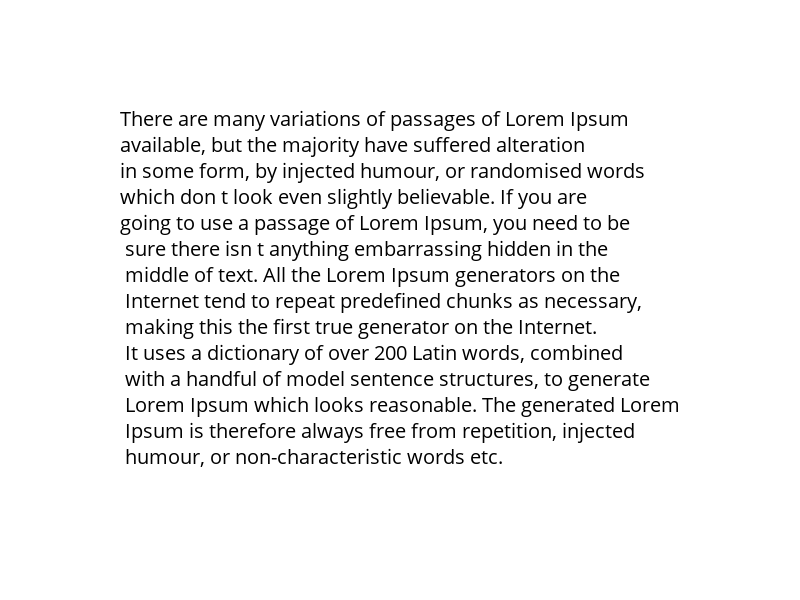

In [86]:
# out = rotate_image(out, 30)
display(out)

In [87]:
result = ocr(out, 'open-sans', f_size)

In [88]:
print(result)

The.re. .are. m.an.y .v.ari.atio,ns o,f p,.ass.a.g.e.s o,f Lo,re.m l p,sum
.a.v.ail.ab,le.., b,ut the. m.ajo,rit.y h.a.ve. suff-e.re.d .alte.r.atio,n
in so,me. fo,rm., b,.y inje.cte.d humo,ur., o,r r.ando,mise.d .w,o,rds
.w,hich do,n t lo,o,k e..ve.n sli.g.htl.y b,e.lie..v.ab,le.. l f .yo,u .are.
.g.o,in.g. to, use. .a p,.ass.a.g.e. o,f Lo,re.m l p,sum., .yo,u ne.e.d to, b,e.
-sure- the.re. isn t .an.ythin.g. e.mb,.arr.assin.g. hidde.n in the.
 middle. o,f te.xt. .A.ll the. Lo,re.m l p,sum .g.e-ne.r.ato,rs o,n the.
 l nte.rne.t te.nd to, re.p,e..at p,re.de.fine.d chunks .as ne.ce.ss.ar.y.,
 m.akin.g. this the. first true. .g.e.ne.r.ato,r o,n the. l nte.rne.t.
 l t use.s-.a dictio,n.ar.y o,f o,.ve.r 2.0,.0, L.atin .w,o,rds., co,mb,ine.d
 .w,ith .a h.andful o,f mo,de.l se.nte.nce. structure.s., to, .g.e.ne.r.ate.
 Lo,re.m l p,sum .w,hich lo,o,ks re..aso,n.ab,le.. The. .g.e.ne.r-.ate.d Lo,re.m
 l p,sum is the.re.fo,re. .al.w,.a.ys fre.e. fro,m re.p,e.titio,n., inje.cte.d
 humo,ur. o,r no,

In [89]:
print(1 - Levenshtein.distance(result, txt) / max(len(result), len(txt)))

0.7096774193548387


In [91]:
def edist_dist2(s1, s2):
    s1 = list(filter(lambda x: x in characters and not x in '.,', list(s1)))
    s2 = list(filter(lambda x: x in characters and x not in '.,', list(s2)))
    return 1 - Levenshtein.distance(s1, s2) / max(len(s1), len(s2))

In [155]:
edist_dist2("1234567890", "0987654321")

0.0